In [1]:
# Importing packages and libraries
import os
import pandas as pd 
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats
import tensorflow as tf
from pylab import rcParams

%matplotlib inline

from sklearn.model_selection import train_test_split
from numpy.random import seed
from tensorflow import set_random_seed

from keras.layers import Input, Dropout
from keras.layers.core import Dense
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.callbacks import ModelCheckpoint, TensorBoard

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

/home/sayan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df= pd.read_csv('data/creditcard.csv')

In [3]:
df.shape

(284807, 31)

In [4]:
df.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

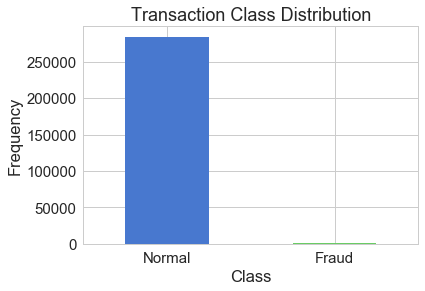

In [5]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind='bar', rot=0)
plt.title('Transaction Class Distribution')
plt.xticks(range(2), LABELS)
plt.xlabel('Class')
plt.ylabel('Frequency')

In [6]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

frauds.shape

(492, 31)

In [7]:
normal.shape

(284315, 31)

In [8]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [9]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

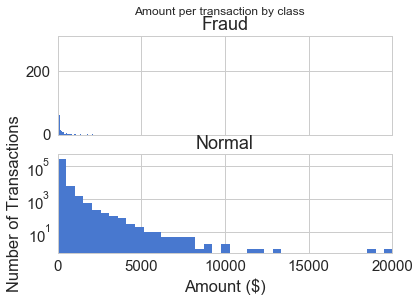

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
f.suptitle('Amount per transaction by class')

bins = 50
ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

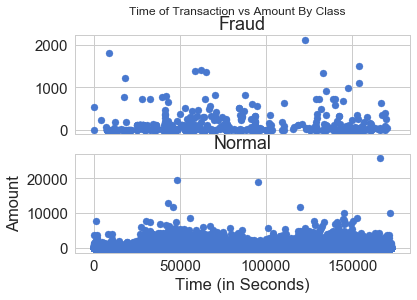

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
f.suptitle('Time of Transaction vs Amount By Class')

bins = 50
ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

# Preparing The Data

In [12]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis = 1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [13]:
X_train, X_test = train_test_split(data, test_size = 0.2, random_state = RANDOM_SEED)

X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis = 1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis = 1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

(227451, 29)

In [14]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape = (input_dim, ))

encoder = Dense(encoding_dim, activation = 'tanh', activity_regularizer = regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation = 'relu')(encoder)

decoder = Dense(int(encoding_dim / 2), activation = 'tanh')(encoder)
decoder = Dense(input_dim, activation = 'relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs = decoder)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [15]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.h5', verbose = 0, save_best_only = True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images = True)

history = autoencoder.fit(X_train, X_train, epochs = nb_epoch, batch_size = batch_size,
                         shuffle = True,
                         validation_data = (X_test, X_test),
                         verbose=1,
                         callbacks=[checkpointer, tensorboard])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 22s - loss: 0.8314 - acc: 0.5883 - val_loss: 0.8156 - val_acc: 0.6448
Epoch 2/100
227451/227451 [==============================] - 24s - loss: 0.7717 - acc: 0.6500 - val_loss: 0.7930 - val_acc: 0.6508
Epoch 3/100
227451/227451 [==============================] - 23s - loss: 0.7582 - acc: 0.6560 - val_loss: 0.7859 - val_acc: 0.6541
Epoch 4/100
227451/227451 [==============================] - 23s - loss: 0.7538 - acc: 0.6551 - val_loss: 0.7834 - val_acc: 0.6561
Epoch 5/100
227451/227451 [==============================] - 24s - loss: 0.7499 - acc: 0.6521 - val_loss: 0.7799 - val_acc: 0.6551
Epoch 6/100
227451/227451 [==============================] - 23s - loss: 0.7478 - acc: 0.6519 - val_loss: 0.7791 - val_acc: 0.6475
Epoch 7/100
227451/227451 [==============================] - 23s - loss: 0.7465 - acc: 0.6

227451/227451 [==============================] - 20s - loss: 0.7246 - acc: 0.6644 - val_loss: 0.7565 - val_acc: 0.6675
Epoch 61/100
227451/227451 [==============================] - 19s - loss: 0.7252 - acc: 0.6648 - val_loss: 0.7586 - val_acc: 0.6665
Epoch 62/100
227451/227451 [==============================] - 20s - loss: 0.7249 - acc: 0.6651 - val_loss: 0.7597 - val_acc: 0.6691
Epoch 63/100
227451/227451 [==============================] - 20s - loss: 0.7249 - acc: 0.6639 - val_loss: 0.7568 - val_acc: 0.6633
Epoch 64/100
227451/227451 [==============================] - 20s - loss: 0.7249 - acc: 0.6645 - val_loss: 0.7576 - val_acc: 0.6646
Epoch 65/100
227451/227451 [==============================] - 20s - loss: 0.7250 - acc: 0.6641 - val_loss: 0.7597 - val_acc: 0.6664
Epoch 66/100
227451/227451 [==============================] - 20s - loss: 0.7247 - acc: 0.6634 - val_loss: 0.7624 - val_acc: 0.6556
Epoch 67/100
227451/227451 [==============================] - 19s - loss: 0.7247 - acc: 0

In [16]:
autoencoder = load_model('model.h5')

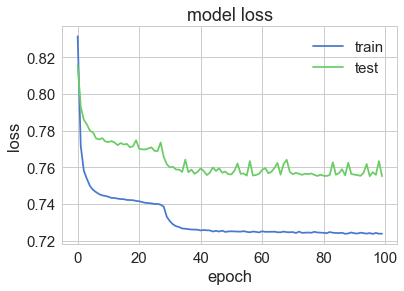

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');